In [1]:
%matplotlib inline
from importlib import reload
from __future__ import print_function, division

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from itertools import product
from functools import partial
from sklearn.datasets import make_sparse_spd_matrix
from sklearn.datasets.base import Bunch
from sklearn.utils.extmath import squared_norm
from sklearn.covariance import GraphLasso, empirical_covariance
from sklearn.datasets.base import Bunch
from sklearn.model_selection import GridSearchCV, ShuffleSplit
from sklearn.gaussian_process import kernels

from regain import prox; reload(prox)
from regain.covariance import time_graphical_lasso_; reload(time_graphical_lasso_);
import time

from regain.bayesian import wishart_process_; reload(wishart_process_)
from regain.bayesian import stats; reload(stats)

from regain import utils; reload(utils);


# ISING

In [2]:
#devo generare dati temporali.. nel dubbio potrei farli tutti uguali, per cominciare
#import regain.datasets.time; reload(regain.datasets.time)
import regain._datasets.ising; reload(regain._datasets.ising)
import regain.datasets; reload(regain.datasets)
from regain.datasets import make_dataset

samples, thetas = make_dataset(
        n_samples=100, n_dim_obs=5,  T=10,  update_theta='l1',
 distribution='ising', change=2)

l1


In [397]:
import regain.generalized_linear_model.ising; reload(regain.generalized_linear_model.ising)
from regain.generalized_linear_model.ising import Ising_GLM_GM
import regain.model_selection.stability_optimization; reload(regain.model_selection.stability_optimization)

from regain.model_selection.stability_optimization import GraphicalModelStabilitySelection

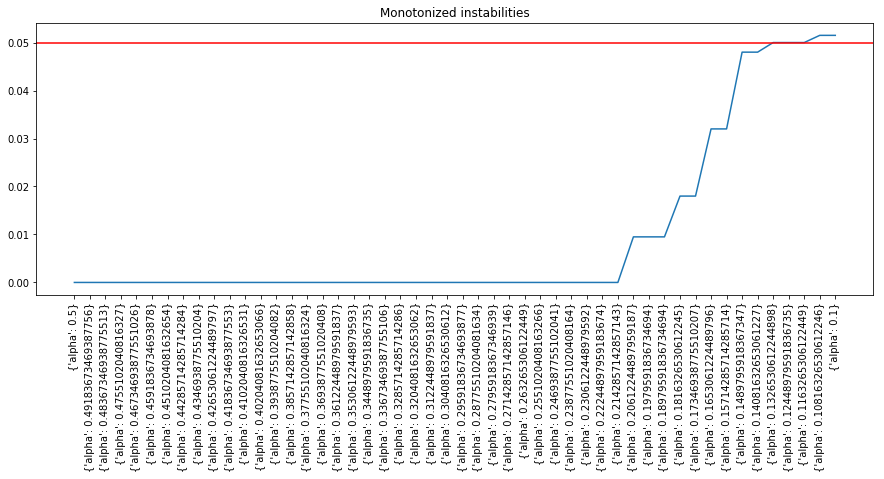

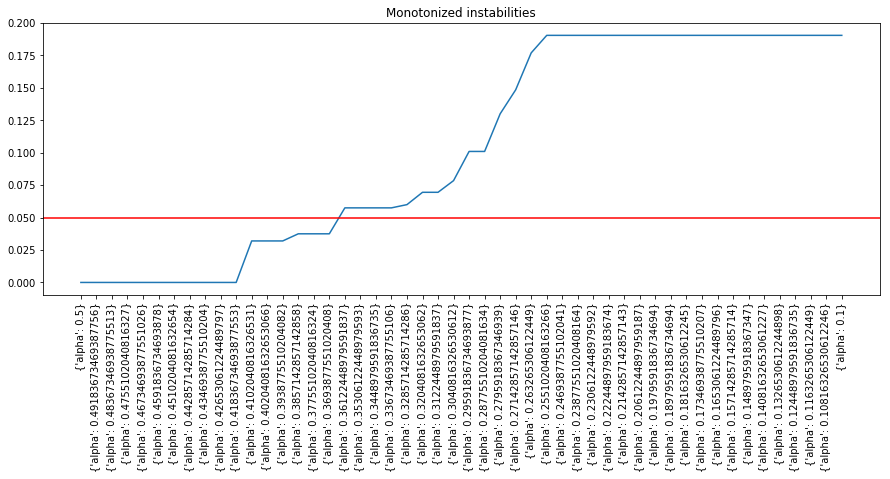

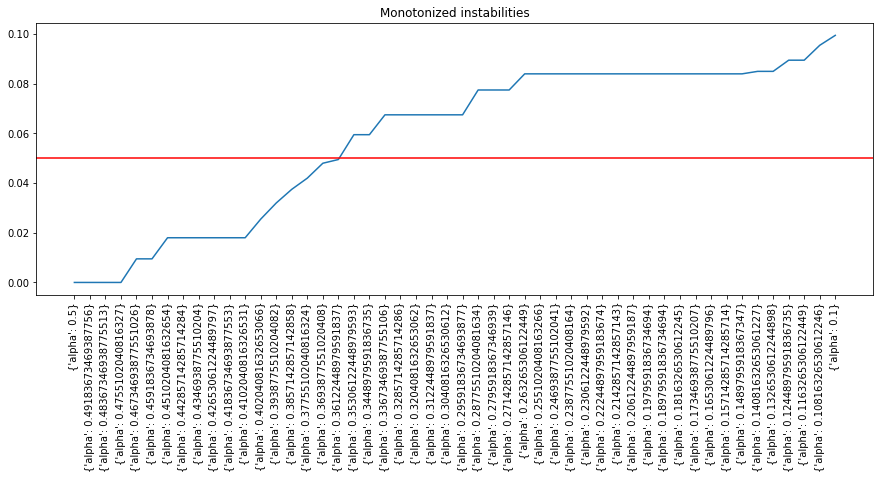

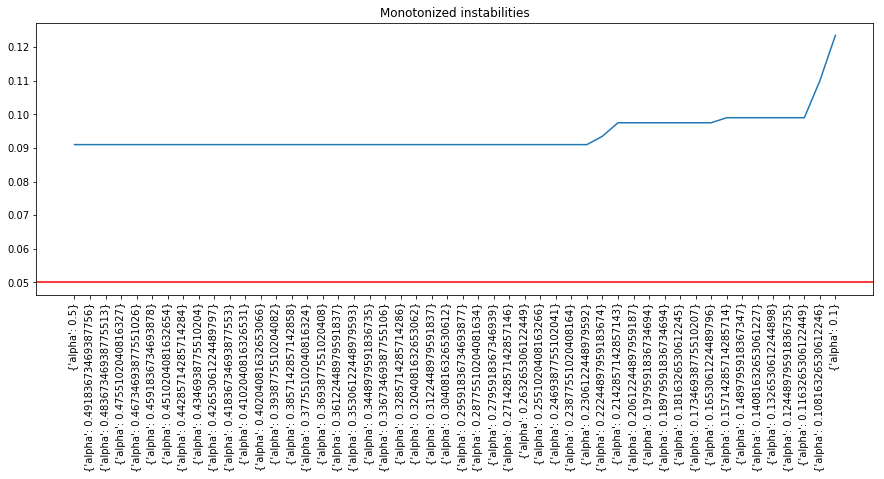

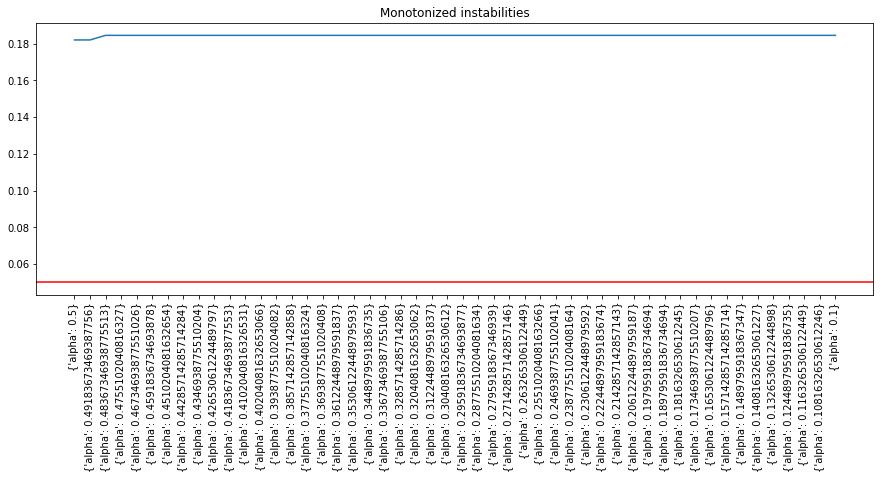

In [ ]:
ising_mdl = Ising_GLM_GM(alpha=0.32, mode='symmetric_fbs', verbose=0)

params = []
estimators = []
for i in range(10):
    cv = GraphicalModelStabilitySelection(ising_mdl, param_grid={'alpha':np.linspace(0.1, 0.5, 50)}, plot=True,
                                          sampling_size=80,
                                         n_repetitions=20)
    cv.fit(samples[i])
    params.append(cv.best_params_['alpha'])
    estimators.append(cv.best_estimator_)

In [374]:
params

[0.4102040816326531, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]

In [380]:
precisions = []
for e in estimators:
    precisions.append(e.precision_)
# ising_mdl = Ising_GLM_GM(alpha=np.mean(params), mode='symmetric_fbs', verbose=0)
# ising_mdl.fit(samples[0])
# utils.structure_error(np.array(thetas[0]), np.array(ising_mdl.precision_), no_diagonal=True)

In [382]:
ising_mdl.get_params()

{'alpha': 0.4910204081632653,
 'compute_objective': True,
 'max_iter': 100,
 'mode': 'symmetric_fbs',
 'reconstruction': 'union',
 'return_history': True,
 'return_n_iter': False,
 'rho': 1,
 'rtol': 0.0001,
 'tol': 0.0001,
 'verbose': 0}

In [381]:
utils.structure_error(np.array(thetas), np.array(precisions), no_diagonal=True)

{'tp': 64,
 'tn': 82,
 'fp': 8,
 'fn': 46,
 'precision': 0.8888888888888888,
 'recall': 0.5818181818181818,
 'f1': 0.7032967032967034,
 'accuracy': 0.584,
 'false_omission_rate': 0.359375,
 'fdr': 0.1111111111111111,
 'npv': 0.640625,
 'prevalence': 0.44,
 'miss_rate': 0.41818181818181815,
 'fall_out': 0.08888888888888889,
 'specificity': 0.9111111111111111,
 'plr': 6.545454545454545,
 'nlr': 0.458980044345898,
 'dor': 14.26086956521739,
 'balanced_accuracy': 0.7464646464646465,
 'average_precision': 0.6861211924503063}

In [394]:
import regain.generalized_linear_model.ising; reload(regain.generalized_linear_model.ising)
import regain.generalized_linear_model.time; reload(regain.generalized_linear_model.time)
from regain.generalized_linear_model.time import TemporalIsingModel


from sklearn.gaussian_process import kernels

kernel = kernels.RBF(length_scale=0.5)(np.arange(10)[:, None])
#kernel = np.ones((10,10))*1
#np.fill_diagonal(kernel, 1)
mdl = TemporalIsingModel(
        alpha=np.mean(params), psi='l1', assume_centered=True, rtol=1e-5, tol=1e-4,
        max_iter=300, rho=1.,  kernel=kernels.RBF(), ker_param='auto', init='zeros', verbose=0)

X = np.vstack(samples)
y = np.array([np.ones(x.shape[0]) * i
              for i, x in enumerate(samples)]).flatten().astype(int)
#base_results(mdl, X, y, K, thetas, ells, search_spaces=None)

In [395]:
import regain.model_selection.stability_optimization; reload(regain.model_selection.stability_optimization)
from regain.model_selection.stability_optimization import GraphicalModelStabilitySelection
cv = GraphicalModelStabilitySelection(mdl, param_grid={'alpha':np.linspace(0.1, 0.5, 50)},
                                      sampling_size=800, plot=True, 
                                      n_repetitions=20)
cv.fit(X, y)

TypeError: __call__() got an unexpected keyword argument 'constant_value'

In [377]:
mdl.fit(X, y)
utils.structure_error(np.array(thetas), mdl.precision_, no_diagonal=True)

{'tp': 66,
 'tn': 80,
 'fp': 10,
 'fn': 44,
 'precision': 0.868421052631579,
 'recall': 0.6,
 'f1': 0.7096774193548387,
 'accuracy': 0.584,
 'false_omission_rate': 0.3548387096774194,
 'fdr': 0.13157894736842105,
 'npv': 0.6451612903225806,
 'prevalence': 0.44,
 'miss_rate': 0.4,
 'fall_out': 0.1111111111111111,
 'specificity': 0.8888888888888888,
 'plr': 5.4,
 'nlr': 0.45000000000000007,
 'dor': 11.999999999999998,
 'balanced_accuracy': 0.7444444444444445,
 'average_precision': 0.6934731934731935}

In [165]:
sampling_size = min(int(10*np.sqrt(1000)), 900)
        
ss = GraphicalModelStabilitySelection(mdl, n_repetitions=100, sampling_size=sampling_size, 
                                              param_grid={'alpha':np.linspace(1e-5, 1e3, 100)},
                                     verbose=1, n_jobs=8)
ss.fit(X, y)

Fitting 100 folds for each of 100 candidates, totalling 10000 fits


/home/vero/miniconda2/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1678: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/vero/git_repos/regain/regain/model_selection/stability_optimization.py:187: UserWarning: Changing sampling size, divisible for the number of classes.
  warnings.warn("Changing sampling size, divisible for the "
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.8s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:  4.3min
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed: 22.4min
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed: 63.8min
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed: 139.2min
[Parallel(n_jobs=8)]: Done 1784 tasks      | elapsed: 256.8min
[Parallel(n_jobs=8)]: Done 2434 tasks      | elapsed: 422.0min
[Parallel(n_jobs=8)]: Done 3184 tasks      | elapsed:

[0.       0.       0.243938 0.245594 0.245594 0.245594 0.245594 0.245594
 0.245594 0.245594 0.245594 0.245594 0.245594 0.245594 0.245594 0.245594
 0.245594 0.245594 0.245594 0.245594 0.245594 0.245594 0.245594 0.245594
 0.245594 0.245594 0.245594 0.245594 0.245594 0.245594 0.245594 0.245594
 0.245594 0.245594 0.245594 0.245594 0.245594 0.245594 0.245594 0.245594
 0.245594 0.245594 0.245594 0.245594 0.245594 0.245594 0.245594 0.245594
 0.245594 0.245594 0.245594 0.245594 0.245594 0.245594 0.245594 0.245594
 0.245594 0.245594 0.245594 0.245594 0.245594 0.245594 0.245594 0.245594
 0.245594 0.245594 0.245594 0.245594 0.245594 0.245594 0.245594 0.245594
 0.245594 0.245594 0.245594 0.245594 0.245594 0.245594 0.245594 0.245594
 0.245594 0.245594 0.245594 0.245594 0.245594 0.245594 0.245594 0.245594
 0.245594 0.245594 0.245594 0.245594 0.245594 0.245594 0.245594 0.245594
 0.245594 0.245594 0.245594 0.245594]


GraphicalModelStabilitySelection(cv=StratifiedShuffleSplit(n_splits=100, random_state=None, test_size=690,
            train_size=310),
                 error_score='raise-deprecating',
                 estimator=TemporalIsingModel(alpha=0.7, assume_centered=0, compute_objective=True,
          distribution='ising', init='zeros', ker_param=1,
          kernel=array([[1., 0., ..., 0., 0.],
       [0., 1., ..., 0., 0.],
       ...,
       [0., 0., ..., 1., 0.],
       [0., 0., ..., 0., 1.]]),
          max_iter=300, max_iter_ext=100, psi='l1', return_history=False,
          rho=1.0, rtol=1e-05, tol=0.0001, update_rho_options=None,
          verbose=0),
                 iid='deprecated', n_jobs=8, n_repetitions=100,
                 param_grid={'alpha': array([1.00000e+05, 9.89999e-02, ..., 1.01020e-03, 1.00000e-03])},
                 pre_dispatch='2*n_jobs', refit=True,
                 return_train_score=False, sampling_size=310, scoring=None,
                 verbose=1)

In [167]:
utils.structure_error(np.array(thetas), np.array(ss.best_estimator_.precision_), no_diagonal=True)

{'tp': 0,
 'tn': 90,
 'fp': 0,
 'fn': 110,
 'precision': 0,
 'recall': 0.0,
 'f1': 0,
 'accuracy': 0.36,
 'false_omission_rate': 0.55,
 'fdr': 1,
 'npv': 0.45,
 'prevalence': 0.44,
 'miss_rate': 1.0,
 'fall_out': 0.0,
 'specificity': 1.0,
 'plr': 0,
 'nlr': 1.0,
 'dor': 0.0,
 'balanced_accuracy': 0.5,
 'average_precision': 0.18}

In [148]:
ss.best_params_

{'alpha': 1e-05}

In [ ]:
X.shape

In [ ]:
samples[0].shape

In [ ]:
len(samples)